# Airbnb - Modelling

**Content of this notebook:**
1. Correlations
2. Feature Selection
3. Modelling:
    - Linear Regression
    - Random Forest
    - XGBoost
    - CatBoost
4. Conclusion

*For the data preparation and exploration, please see the notebook called 'Airbnb - Data Preparation and Exploration'.*

Importing the libraries used in this notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
import shap  
shap.initjs()
import pickle

Unpickle the dateframe prepared in the previous notebook.

In [2]:
with open('airbnb_clean.pkl', 'rb') as f_df:
    airbnb = pickle.load(f_df)

## 1. Correlations

First I will check out the correlations between the dependent variable (price in usd per night) and the independent variables. I have too many variables to plot the correlations between all variables. However, I am not too worried about multicollinearity, because for most of the models I will apply (with exception of the linear regression) multicollinearity isn't an issue.

<AxesSubplot:>

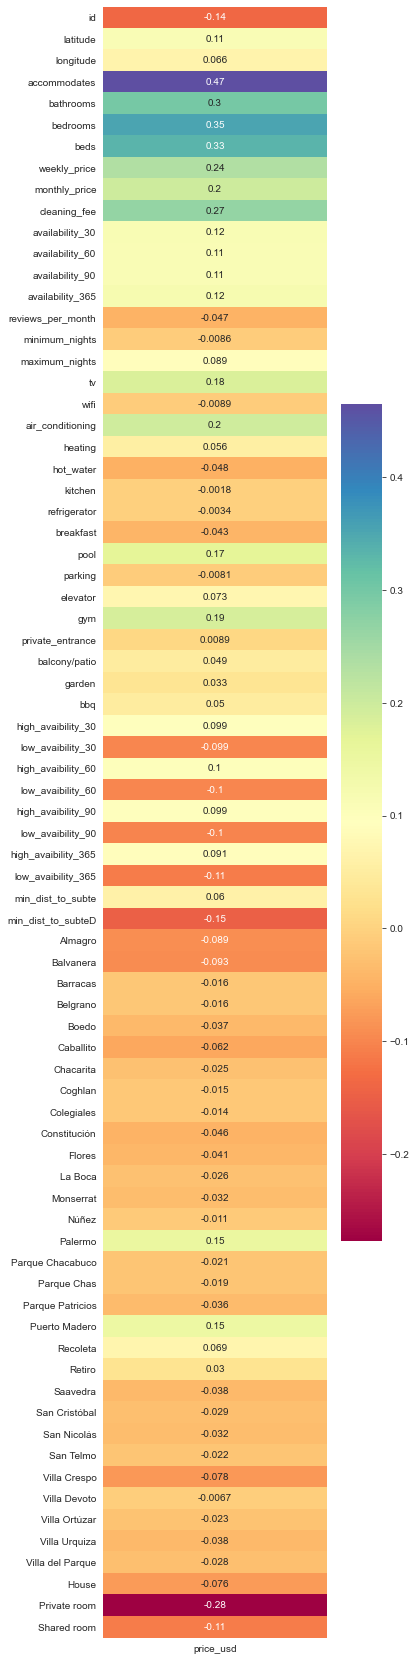

In [3]:
palette=sns.color_palette("Spectral", n_colors=256)

plt.figure(figsize=(5,30))
sns.heatmap(airbnb.corr().loc[~airbnb.corr().columns.isin(['price', 'price_usd']),['price_usd']], square=False,\
            annot=True, cmap=palette)

There are no variables that have a very strong correlation with the price per night, but the variables below are the ones  that correlate most (correlation > 0.10). I excluded the weekly and monthly price, because I won't have this information. The goal of the model is to predict prices, in particular the price per night. 

- accomodates (0.47)
- bedrooms (0.35)
- beds (0.33)
- bathrooms (0.3)
- private room (-0.28)
- cleaning fee (0.27)
- air conditioning (0.2)
- gym (0.19)
- tv (0.18)
- pool (0.17)
- puerto madero (0.15)
- palermo (0.15)
- minimum distance to subte D (-0.15)
- availabilty (0.11-0.12)
- shared room (-0.11)
- low availability 365 (-0.11)
- latitude (0.11)

## 2. Feature selection

The price distribution is skewed to the right. A log transformation makes this variable closer to a normal distribution. I will use the log of 'price_usd' as the dependent variable in the models below.

Text(0, 0.5, 'Count')

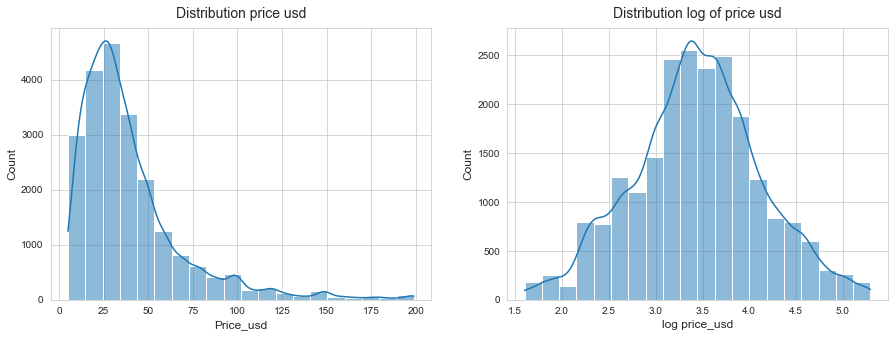

In [4]:
f, axes = plt.subplots(2, 1, figsize=(15,5))

ax1 = plt.subplot(121)
sns.histplot(airbnb.price_usd, kde=True, bins=20, ax=ax1)
plt.title('Distribution price usd', fontsize=14, pad=10)
plt.xlabel('Price_usd', fontsize=12)
plt.ylabel('Count', fontsize=12)

ax2 = plt.subplot(122)
sns.histplot(np.log(airbnb.price_usd), kde=True, bins=20, ax=ax2)
plt.title('Distribution log of price usd', fontsize=14, pad=10)
plt.xlabel('log price_usd', fontsize=12)
plt.ylabel('Count', fontsize=12)

I start by assigning all my independent variables to 'X' and the loc of 'price_usd' to 'y'.

Because I try to limit the amount of information I need to collect in the application, I decided not to include the features related to availability. Although including this information improves the models a little bit, it is too much detailed information too ask from users of the application.

In [5]:
X = airbnb[['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
            'cleaning_fee', 'minimum_nights', 'maximum_nights', 'reviews_per_month', 'tv', 
            'wifi', 'air_conditioning', 'heating', 'hot_water', 'kitchen', 'breakfast',
            'pool', 'parking', 'elevator', 'gym', 'private_entrance', 'balcony/patio', 
            'garden', 'bbq', 'min_dist_to_subte', 'min_dist_to_subteD', 'Balvanera', 'Barracas', 
            'Belgrano', 'Boedo', 'Caballito', 'Chacarita', 'Coghlan', 'Colegiales',
            'Constitución', 'Flores', 'La Boca', 'Monserrat', 'Núñez', 'Palermo',
            'Parque Chacabuco', 'Parque Chas', 'Parque Patricios', 'Puerto Madero',
            'Recoleta', 'Retiro', 'Saavedra', 'San Cristóbal', 'San Nicolás',
            'San Telmo', 'Villa Crespo', 'Villa Devoto', 'Villa Ortúzar',
            'Villa Urquiza', 'Villa del Parque', 'House', 'Private room',
            'Shared room']]

y = np.log(airbnb['price_usd'])

I will split the dataset into a train set (80% of the data) and test set (20% of the date).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

I will set KFold at 5 splits with shuffle for all cross validations I will use.

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

I will use recursive feature elimination to select my final features. This leads to better results than without feature selection. I decided to use a model based on decision trees for the feature selection, because during some first try outs I noticed that this type of model works much better on my dataset than linear regressions, so I prefer to optimize the features for this type of model.

I have commented out the section below, because it takes a long time to run, but I am using the features selected by RFECV.

In [8]:
#estimator = XGBRegressor()
#selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error')
#selector.fit(X_train, y_train)

In [9]:
#X.loc[:,selector.support_].columns

In [10]:
features_to_keep = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
                    'beds', 'cleaning_fee', 'minimum_nights', 'maximum_nights',
                    'reviews_per_month', 'tv', 'wifi', 'air_conditioning', 'heating',
                    'hot_water', 'kitchen', 'pool', 'elevator', 'gym',
                    'private_entrance', 'balcony/patio', 'bbq', 'min_dist_to_subte',
                    'min_dist_to_subteD', 'Balvanera', 'Colegiales', 'Constitución',
                    'Monserrat', 'Palermo', 'Puerto Madero', 'Recoleta', 'Retiro',
                    'Saavedra', 'San Cristóbal', 'San Nicolás', 'San Telmo',
                    'Villa Urquiza', 'Private room', 'Shared room']

X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

In [11]:
X_train.shape

(17535, 39)

In [12]:
X_test.shape

(4384, 39)

One of the models I will use is sensitive to the scale of the data, therefore I will normalize X_train and X_test.

In [13]:
stdscaler = preprocessing.StandardScaler()

X_train_norm = pd.DataFrame(stdscaler.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(stdscaler.transform(X_test), columns=X_test.columns)

I will create a funtion that will plot the predictions for the train and test set against their real values.

In [14]:
def plot_predictions(y_pred_train, y_train, y_pred_test, y_test):
    
    fig = plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.scatter(y_pred_train, y_train, s=10, c='b', alpha=0.3, zorder=10)
    plt.plot(y_train, y_train, c='grey')
    plt.xlabel('Predictions model', fontsize=12)
    plt.ylabel('Real values', fontsize=12)
    plt.title('Training predictions vs. Real values', fontsize=14, pad=10)

    plt.subplot(1,2,2)
    plt.plot(y_test, y_test, c='grey')
    plt.scatter(y_pred_test, y_test, s=10, c='g', alpha=0.3, zorder=10)
    plt.xlabel('Predictions model', fontsize=12)
    plt.ylabel('Real values', fontsize=12)
    plt.title('Test predictions vs. Real values', fontsize=14, pad=10)
    
    plt.show()

## 3. Modelling

### 3.1 Linear Regression

First, I will apply a simple Linear Regression model. Since a linear regression is sensitive to the scale of the input variables, I will train this model on the normalized data.

In [15]:
lm = linear_model.LinearRegression()
lm.fit(X_train_norm, y_train)
y_pred_train = lm.predict(X_train_norm)
y_pred_test = lm.predict(X_test_norm)

The graphs below show the prediction for the train and test set against their real values. It seems that the model is having some difficulties predicting low and high values. Real values lower than 2.5 seem to be predicted higher almost all the time. At the same time real values higher than 4.5 seem to be predicted lower. The prediction error for real values between 2.5 and 4.5 seems to be more random.

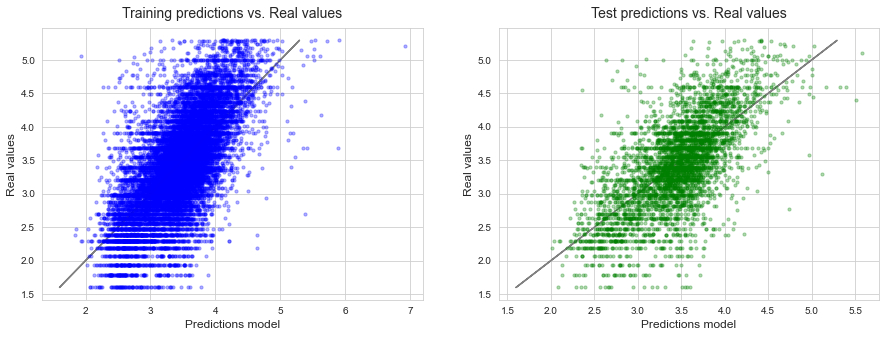

In [16]:
plot_predictions(y_pred_train, y_train, y_pred_test, y_test)

I will create a dataframe to store the results of the metrics MSE and R2 for both the train and test set. This will help me to compare the performance of the different models.

In [17]:
results = pd.DataFrame(columns=['model', 'MSE Train', 'MSE Test', 'R2 Train', 'R2 Test'])

results.loc[0, 'model'] = 'Linear Regresssion'
results.loc[0, 'MSE Train'] = mean_squared_error(y_train, y_pred_train).round(3)
results.loc[0, 'MSE Test'] = mean_squared_error(y_test, y_pred_test).round(3)
results.loc[0, 'R2 Train'] = r2_score(y_train, y_pred_train).round(3)
results.loc[0, 'R2 Test'] = r2_score(y_test, y_pred_test).round(3)

In [18]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.254,0.257,0.461,0.449


The beta coefficients of the different features can tell us something about the importance these features have in the model. Below I have listed the features in descending order of their absolute beta coefficients. The most important features seem to be the amount of guests the airbnb listing can ***accomodate*** (positive effect: the more guest it can accomodate, the higher the predicted price), the neighbourhood ***La Boca*** (negative effect: if the neighbourhood is La Boca, the predicted price is lower), the ***longitude*** (positive effect: the bigger the longitude, the higher the predicted price), the ***latitude*** (positive effect: the bigger the latitude, the higher the predicted price), and the neighbourhood ***Barracas*** (positive effect: if the neighbourhood is Barracas, the predicted price is higher).

In [19]:
sorted(list(zip(X.columns, lm.coef_.round(5))), key=lambda x: abs(x[1]), reverse=True)

[('accommodates', 0.17223),
 ('La Boca', -0.15767),
 ('longitude', 0.11248),
 ('latitude', 0.11159),
 ('Barracas', 0.11),
 ('Monserrat', -0.09125),
 ('cleaning_fee', 0.07063),
 ('bedrooms', 0.07058),
 ('reviews_per_month', -0.06341),
 ('Boedo', 0.06003),
 ('parking', 0.057),
 ('bathrooms', 0.05678),
 ('air_conditioning', 0.04829),
 ('breakfast', 0.04694),
 ('tv', 0.04404),
 ('hot_water', -0.03946),
 ('Belgrano', 0.03606),
 ('garden', 0.03299),
 ('maximum_nights', 0.02716),
 ('minimum_nights', -0.02627),
 ('kitchen', -0.02107),
 ('Constitución', 0.01952),
 ('Chacarita', -0.0186),
 ('balcony/patio', 0.01843),
 ('Caballito', 0.0175),
 ('elevator', -0.01719),
 ('private_entrance', 0.01545),
 ('Balvanera', 0.01462),
 ('Colegiales', 0.01439),
 ('wifi', -0.01383),
 ('pool', 0.01153),
 ('gym', 0.01126),
 ('min_dist_to_subte', 0.00841),
 ('Coghlan', 0.00746),
 ('min_dist_to_subteD', -0.00633),
 ('beds', -0.0062),
 ('Flores', -0.00205),
 ('bbq', -0.00176),
 ('heating', -0.00079)]

### 3.2 Random Forest Regressor

Second, I will apply a Random Forest Regressor. I have optimized the hyperparameters with a randomized search. Below the randomized search part is commented out, because it is computationally heavy.

In [20]:
#rfc =  RandomForestRegressor(random_state=12)

#n_estimators = [100, 500]
#depth = [5, 10, 15, 30]
#max_features = ['auto', 0.7, 0.5, 0.3]
#min_samples_leaf = [3, 5, 7, 10]

#param_grid = dict(n_estimators=n_estimators, max_depth=depth, max_features=max_features, min_samples_leaf=min_samples_leaf)

In [21]:
#model_RF = RandomizedSearchCV(rfc, param_grid, n_iter=20, cv=kf, verbose=0, random_state=12, n_jobs=-1)
#model_RF.fit(X_train, y_train)

In [22]:
#model_RF.best_estimator_

In [23]:
#model_RF.best_score_

In [24]:
model_RF = RandomForestRegressor(n_estimators=500, random_state=12, max_features=0.7, max_depth=30, min_samples_leaf=5)
model_RF.fit(X_train, y_train)
y_pred_train = model_RF.predict(X_train)
y_pred_test = model_RF.predict(X_test)

This  models also seems to have difficulties with predicting the lowest values. Real values below 2.5 are systematically predicted higher. Although this model also predicts values that are too low for real values above 4.5, it gets closer to the real values than the linear regression.

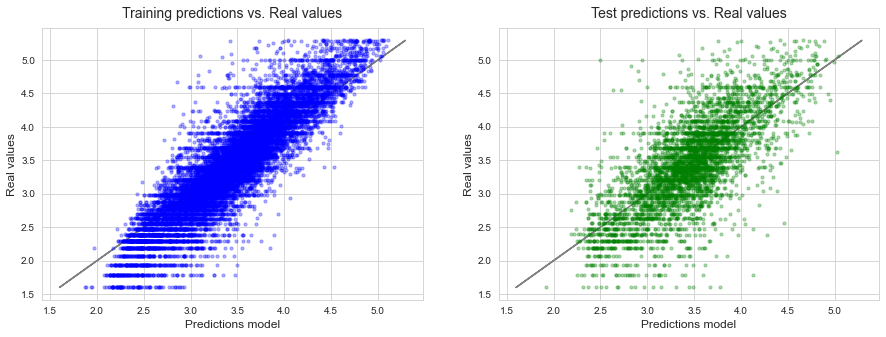

In [25]:
plot_predictions(y_pred_train, y_train, y_pred_test, y_test)

Applying the Random Forest Regressor with all hyperparameters in default led to some very strong overfitting (R2 train: 93,5% vs R2 test: 53,5%). By tuning the hyperparameters with a Randomized Search CV I managed to reduce the overfitting, but I was not able to get rid of it. Nevertheless the test results are better than with a Linear Regression.

In [26]:
results.loc[1, 'model'] = 'Random Forest'
results.loc[1, 'MSE Train'] = mean_squared_error(y_train, y_pred_train).round(3)
results.loc[1, 'MSE Test'] = mean_squared_error(y_test, y_pred_test).round(3)
results.loc[1, 'R2 Train'] = r2_score(y_train, y_pred_train).round(3)
results.loc[1, 'R2 Test'] = r2_score(y_test, y_pred_test).round(3)

In [27]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.254,0.257,0.461,0.449
1,Random Forest,0.102,0.216,0.784,0.537


To get a better understanding of the importance of the different features in the Random Forest model, I will use the Tree Explainer of the Shap library. Because of computational limitations (applying this function on a Random Forest is computational very heavy), I am applying the Tree Explainer to a sample of 1000 rows of the test set, instead of the entire test set.

It shows that the most important features are ***cleaning fee*** (positive effect: the higher cleaning fee, the higher the predicted price), ***accommodates*** (positive effect: the more guests it can accomodate, the higher the predicted price), ***private room*** (negative effect: if the airbnb listing is a private room, the predicted price will be lower), ***reviews_per_month*** (negative effect: the lower the amount of reviews per month, the higher the predicted price) and ***bedrooms*** (positive effect: the more bedrooms, the higher the predicted price).

The negative effect of the reviews per month surprises me. I expected the opposite, assuming that more popular airbnb listings have more reviews and are able to charge higher prices. One possible explanation is that airbnb listings with lower prices are booked more often, and have more reviews than airbnb listings with high prices.

In [28]:
background = X_test.sample(1000)
explainer = shap.TreeExplainer(model_RF, background)
shap_values = explainer.shap_values(background)

100%|===================| 998/1000 [09:32<00:01]        

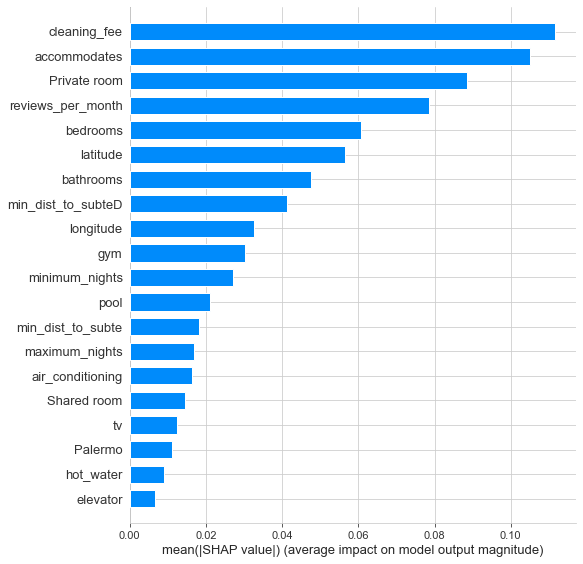

In [29]:
shap.summary_plot(shap_values, background, plot_type="bar")

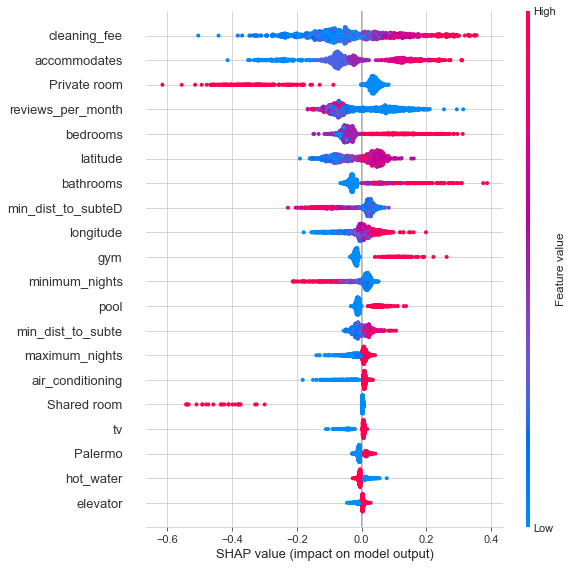

In [30]:
shap.summary_plot(shap_values, background)

### 3.3 XGBoost Regressor

Third, I will apply the XGBoost Regressor. I have optimized the hyperparameters with a randomized search. Below the randomized search part is commented out, because it is computationally heavy.

In [31]:
#xgb =  XGBRegressor()

#learning_rate = [0.05, 0.1, 0.3]
#n_estimators = [100, 500]
#max_depth = [5, 10, 15, 30]

#param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

In [32]:
#model_XGB = RandomizedSearchCV(xgb, param_grid, n_iter=10, cv=kf, verbose=0, random_state=12, n_jobs=-1)
#model_XGB.fit(X_train, y_train)

In [33]:
#model_XGB.best_estimator_

In [34]:
#model_XGB.best_score_

In [35]:
model_XGB = XGBRegressor(max_depth=5, random_state=12)
model_XGB.fit(X_train, y_train)
y_pred_train = model_XGB.predict(X_train)
y_pred_test = model_XGB.predict(X_test)

[17:46:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


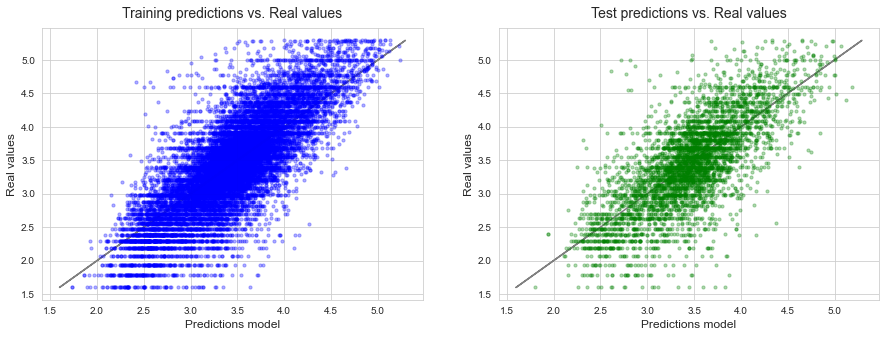

In [36]:
plot_predictions(y_pred_train, y_train, y_pred_test, y_test)

The XGBoost Regressor obtains test results close to the test results of the Random Forest Regressor, but with less overfitting.

In [37]:
results.loc[2, 'model'] = 'XGBoost'
results.loc[2, 'MSE Train'] = mean_squared_error(y_train, y_pred_train).round(3)
results.loc[2, 'MSE Test'] = mean_squared_error(y_test, y_pred_test).round(3)
results.loc[2, 'R2 Train'] = r2_score(y_train, y_pred_train).round(3)
results.loc[2, 'R2 Test'] = r2_score(y_test, y_pred_test).round(3)

In [38]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.254,0.257,0.461,0.449
1,Random Forest,0.102,0.216,0.784,0.537
2,XGBoost,0.176,0.215,0.626,0.539


The most important features in the XGBoost Regressory are ***accommodates*** (positive effect: the more guests it can accomodate, the higher the predicted price), ***private room*** (negative effect: if the airbnb listing is a private room, the predicted price will be lower), ***cleaning fee*** (positive effect: the higher cleaning fee, the higher the predicted price), ***reviews_per_month*** (negative effect: the lower the amount of reviews per month, the higher the predicted price) and ***latitude*** (positive effect: the bigger the latitude, the higher the predicted price). These are similar features as obtained with the Random Forest Regressor.

In [39]:
explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(X_test)

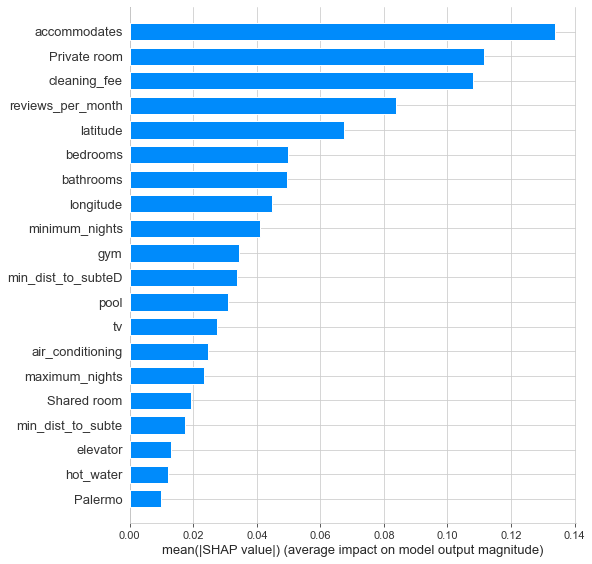

In [40]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

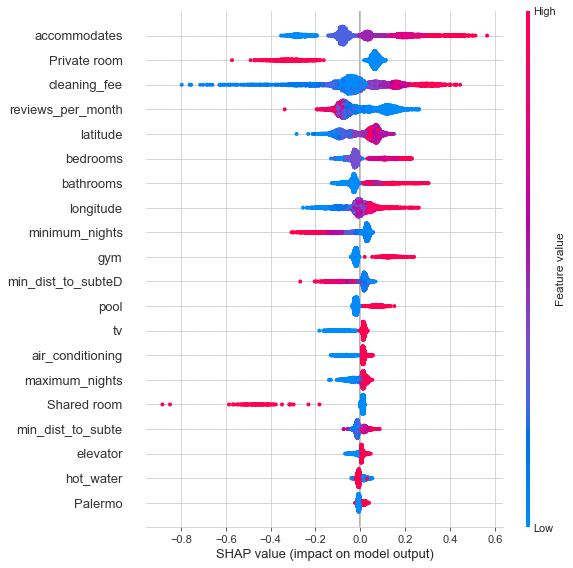

In [41]:
shap.summary_plot(shap_values, X_test)

### 3.4 CatBoost Regresssor

Finally, I will apply the CatBoost Regressor. I have optimized the hyperparameters with a randomized search. Below the randomized search part is commented out, because it is computationally heavy.

In [42]:
#model_catboost = CatBoostRegressor(random_state=2)

#grid = {'learning_rate': [0.03, 0.1],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

#model_catboost.randomized_search(grid, X=X_train, y=y_train, cv=kf, n_iter=10, plot=True)

The performance of the CatBoost Regressor is better with all hyperparameters in default than with the hyperparameters found with a randomized search. Therefore I will apply this model in its default form.

In [43]:
#model_catboost = CatBoostRegressor(random_state=12, depth=6, l2_leaf_reg=9, learning_rate=0.1)
model_catboost = CatBoostRegressor(random_state=12)
model_catboost.fit(X_train, y_train, verbose=False)
y_pred_train = model_catboost.predict(X_train)
y_pred_test = model_catboost.predict(X_test)

The CatBoost Regressor also has problems predicting the lowest values, but it does relatively well with the higher values.

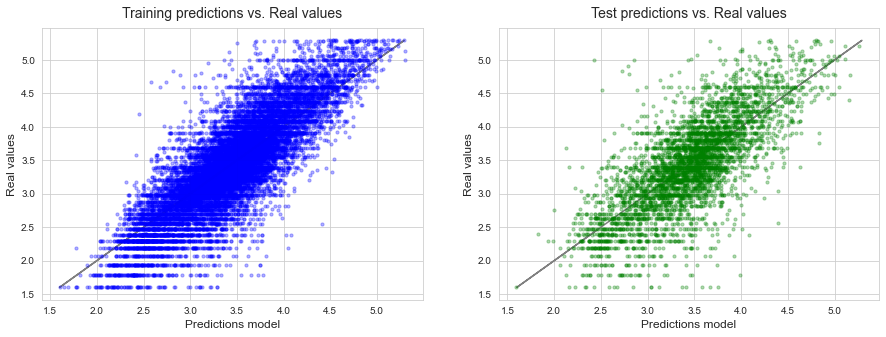

In [44]:
plot_predictions(y_pred_train, y_train, y_pred_test, y_test)

The CatBoost Regressor has the best results for the test set. It overfits less than the Random Forest Regressor, but more than the XGBoost Regressor.

In [45]:
results.loc[3, 'model'] = 'CatBoost'
results.loc[3, 'MSE Train'] = mean_squared_error(y_train, y_pred_train).round(3)
results.loc[3, 'MSE Test'] = mean_squared_error(y_test, y_pred_test).round(3)
results.loc[3, 'R2 Train'] = r2_score(y_train, y_pred_train).round(3)
results.loc[3, 'R2 Test'] = r2_score(y_test, y_pred_test).round(3)

In [46]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.254,0.257,0.461,0.449
1,Random Forest,0.102,0.216,0.784,0.537
2,XGBoost,0.176,0.215,0.626,0.539
3,CatBoost,0.145,0.208,0.693,0.554


The most important features in the CatBoost Regressor are ***cleaning fee*** (positive effect: if the cleaning fee is higher, the predicted price will be higher), ***accommodates*** (positive effect: the more guest it can accomodate, the higher the predicted price), ***private room*** (negative effect: if the airbnb listing is a private room, the predicted price will be lower), ***reviews_per_month*** (negative effect: the lower the amount of reviews per month, the higher the predicted price) and ***latitude*** (positive effect: the bigger the latitude, the higher the predicted price). Similar features as the Random Forest Regressor and the XGBoost Regressor.

In [47]:
explainer = shap.TreeExplainer(model_catboost)
shap_values = explainer.shap_values(X_test)

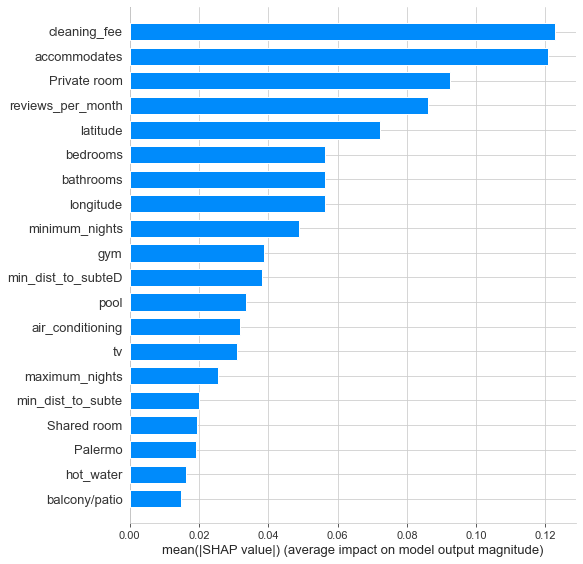

In [48]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

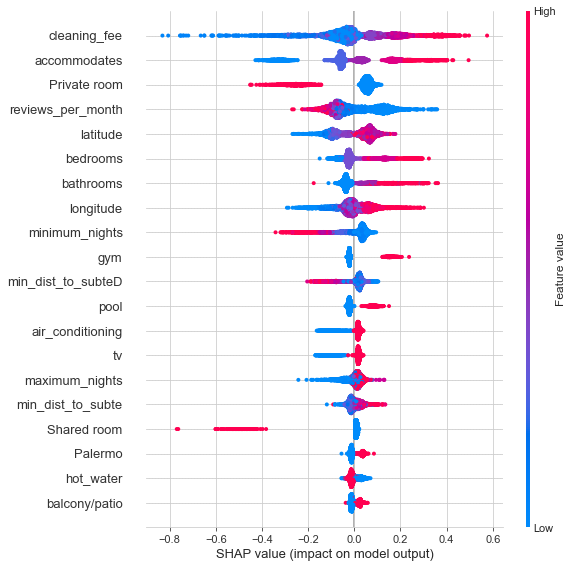

In [49]:
shap.summary_plot(shap_values, X_test)

## 4. Conclusion

Even though it seems to be overfitting, the CatBoost Regressor has the best results on the test set: a mean squared error of 0.208 and an r-squared of 0.554. Therefore I have decided to use this model in my final application.

In [50]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.254,0.257,0.461,0.449
1,Random Forest,0.102,0.216,0.784,0.537
2,XGBoost,0.176,0.215,0.626,0.539
3,CatBoost,0.145,0.208,0.693,0.554


The most important features in the CatBoost Regressor:
- ***Cleaning fee*** (positive effect): the higher cleaning fee, the higher the predicted price.
- ***Accommodates*** (positive effect): the more guests an airbnb listing can accomodate, the higher the predicted price.
- ***Private room*** (negative effect): if the airbnb listing is a private room, the predicted price will be lower.
- ***Reviews per month*** (negative effect): the lower the amount of reviews per month, the higher the predicted price.
- ***Latitude*** (positive effect): the bigger the latitude (the more north), the higher the predicted price.

Saving the final model as a pickle.

In [51]:
with open('airbnb_model_catboost.pkl', 'wb') as f_model:
    pickle.dump(model_catboost, f_model)